

# Statoil/C-CORE Iceberg Classifier

![cover](https://drive.google.com/uc?export=view&id=1QdSEwYcw0NCXiUflW45ehWiULtD38Tpy)

## Motivation
Drifting icebergs present threats to navigation and activities in areas such as offshore of the East Coast of Canada.

Currently, many institutions and companies use aerial reconnaissance and shore-based support to monitor environmental conditions and assess risks from icebergs. However, in remote areas with particularly harsh weather, these methods are not feasible, and the only viable monitoring option is via satellite.

## Goal
Statoil, an international energy company operating worldwide, has worked closely with companies like C-CORE. C-CORE have been using satellite data for over 30 years and have built a computer vision based surveillance system. To keep operations safe and efficient, Statoil is interested in getting a fresh new perspective on how to use machine learning to more accurately detect and discriminate against threatening icebergs as early as possible.

In this project we are going to build an algorithm that automatically identifies if a remotely sensed target is a ship or iceberg. Improvements made will help drive the costs down for maintaining safe working conditions.

# Data Explortion

Dataset found in: `train.json`, `test.json`  
The data (`train.json`, `test.json`) is presented in json format.  
The training data has 1603 data points, where the testing 8424  data has data points.

## Data fields


The files consist of a list of images, and for each image, you can find the following fields:

- **id** - the id of the image  
- **band_1, band_2** - the flattened image data. Each band has 75x75 pixel values in the list, so the list has 5625 elements. Note that these values are not the normal non-negative integers in image files since they have physical meanings - these are float numbers with unit being dB. Band 1 and Band 2 are signals characterized by radar backscatter produced from different polarizations at a particular incidence angle. The polarizations correspond to HH (transmit/receive horizontally) and HV (transmit horizontally and receive vertically). More background on the satellite imagery can be found here.  
- **inc_angle** - the incidence angle of which the image was taken. Note that this field has missing data marked as "na", and those images with "na" incidence angles are all in the training data to prevent leakage.  
- **is_iceberg** - the target variable, set to 1 if it is an iceberg, and 0 if it is a ship. This field only exists in train.json.


# Getting Started

In [1]:
import numpy as np
import pandas as pd
import cv2                
import matplotlib.pyplot as plt
import itertools

from sklearn.model_selection  import train_test_split
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score, roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam, SGD

%matplotlib inline


Using TensorFlow backend.


In [2]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))
# Any results you write to the current directory are saved as output.

['statoil-iceberg-classifier-challenge', 'statoil-model-weights']


## Loading Data

In [3]:
# classes
classes = ['Ship', 'Iceberg']
classes_dict = {0:'Ship', 1:'Iceberg'}

In [4]:
train = pd.read_json("../input/statoil-iceberg-classifier-challenge/train.json")
print("Training data shape:", train.shape)
train.head()

Training data shape: (1604, 5)


,band_1,band_2,id,inc_angle,is_iceberg
0,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",dfd5f913,43.9239,0
1,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",e25388fd,38.1562,0
2,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",58b2aaa0,45.2859,1
3,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",4cfc3a18,43.8306,0
4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",271f93f4,35.6256,0


In [5]:
test = pd.read_json("../input/statoil-iceberg-classifier-challenge/test.json")
print("Testing data shape:", test.shape)
test.head()

Testing data shape: (8424, 4)


,band_1,band_2,id,inc_angle
0,"[-15.863251, -15.201077, -17.887735, -19.17248...","[-21.629612, -21.142353, -23.908337, -28.34524...",5941774d,34.966400
1,"[-26.058969497680664, -26.058969497680664, -26...","[-25.754207611083984, -25.754207611083984, -25...",4023181e,32.615072
2,"[-14.14109992980957, -15.064241409301758, -17....","[-14.74563980102539, -14.590410232543945, -14....",b20200e4,37.505433
3,"[-12.167478, -13.706167, -16.54837, -13.572674...","[-24.32222, -26.375538, -24.096739, -23.8769, ...",e7f018bb,34.473900
4,"[-23.37459373474121, -26.02718162536621, -28.1...","[-25.72234344482422, -27.011577606201172, -23....",4371c8c3,43.918874


## Data Distribution (training data)

1    753
0    851
Name: is_iceberg, dtype: int64


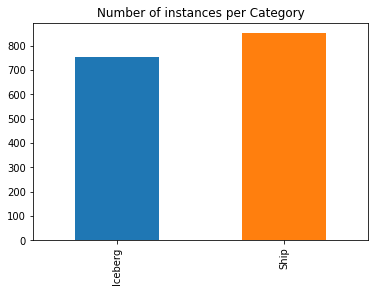

In [6]:
dt = pd.value_counts(train['is_iceberg'], ascending=True)
print(dt)
# convert class id to class name
dt.index = dt.index.map(classes_dict)
dt.plot.bar(title="Number of instances per Category")


In [105]:
def plot_histogram(data1,data2, title ,nbins=50):
    minval = min(data1.min(), data2.min())
    maxval = max(data1.max(), data2.max())
    #meanval = int(data.mean())
    #stdval = int(data.std())
    plt.figure(figsize=(6,4))
    plt.hist(data1,range=[minval,maxval],bins=nbins,color='b',alpha=0.5, label="Iceberg")
    plt.hist(data2,range=[minval,maxval],bins=nbins,color='k',alpha=0.5, label="Ship")
    plt.title('Histogram of ' + title)
    plt.legend()
    plt.xlim([minval,maxval])
    #label = r'$\mu=' + str(meanval) + ',\ \sigma=' + str(stdval) + '$'
    #plt.text(minval-2, 20, label)
    plt.xlabel(title)
    plt.ylabel('Freq')
    
    plt.show()
    


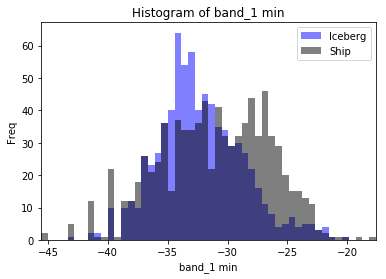

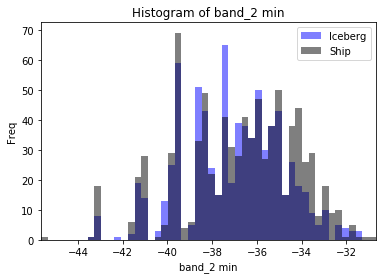

In [107]:
band_1_min_icbergs = np.array([np.array(band).min() for band in train[train.is_iceberg==1]["band_1"]])
band_1_min_ships = np.array([np.array(band).min() for band in train[train.is_iceberg==0]["band_1"]])
plot_histogram(band_1_min_icbergs, band_1_min_ships, "band_1 min")

band_2_min_icbergs = np.array([np.array(band).min() for band in train[train.is_iceberg==1]["band_2"]])
band_2_min_ships = np.array([np.array(band).min() for band in train[train.is_iceberg==0]["band_2"]])
plot_histogram(band_2_min_icbergs, band_2_min_ships, "band_2 min")

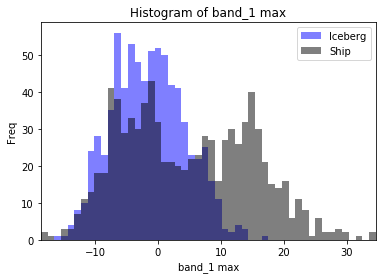

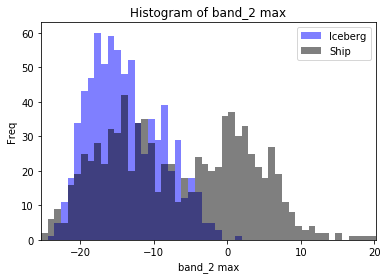

In [110]:
band_1_max_icbergs = np.array([np.array(band).max() for band in train[train.is_iceberg==1]["band_1"]])
band_1_max_ships = np.array([np.array(band).max() for band in train[train.is_iceberg==0]["band_1"]])
plot_histogram(band_1_max_icbergs, band_1_max_ships, "band_1 max")

band_2_max_icbergs = np.array([np.array(band).max() for band in train[train.is_iceberg==1]["band_2"]])
band_2_max_ships = np.array([np.array(band).max() for band in train[train.is_iceberg==0]["band_2"]])
plot_histogram(band_2_max_icbergs, band_2_max_ships, "band_2 max")

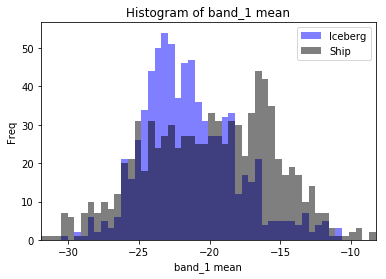

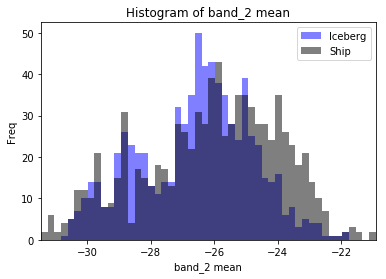

In [109]:
band_1_mean_icbergs = np.array([np.array(band).mean() for band in train[train.is_iceberg==1]["band_1"]])
band_1_mean_ships = np.array([np.array(band).mean() for band in train[train.is_iceberg==0]["band_1"]])
plot_histogram(band_1_mean_icbergs, band_1_mean_ships, "band_1 mean")

band_2_mean_icbergs = np.array([np.array(band).mean() for band in train[train.is_iceberg==1]["band_2"]])
band_2_mean_ships = np.array([np.array(band).mean() for band in train[train.is_iceberg==0]["band_2"]])
plot_histogram(band_2_mean_icbergs, band_2_mean_ships, "band_2 mean")

In [ ]:
band_1_std_icbergs = np.array([np.array(band).std() for band in train[train.is_iceberg==1]["band_1"]])
band_1_std_ships = np.array([np.array(band).std() for band in train[train.is_iceberg==0]["band_1"]])
plot_histogram(band_1_std_icbergs, band_1_std_ships, "band_1 std")

band_2_std_icbergs = np.array([np.array(band).std() for band in train[train.is_iceberg==1]["band_2"]])
band_2_std_ships = np.array([np.array(band).std() for band in train[train.is_iceberg==0]["band_2"]])
plot_histogram(band_2_std_icbergs, band_2_std_ships, "band_2 std")

## Viewing Sample Data

In [7]:
# get random samples
samlples_num = 3
iceberg_samples = train[train.is_iceberg==1].sample(n=samlples_num)
ships_samples = train[train.is_iceberg==0].sample(n=samlples_num)

In [8]:
def plot_bands(imgs):
    # Plot band_1
    fig = plt.figure(1,figsize=(15,15))
    for i in range(samlples_num):
        ax = fig.add_subplot(1,samlples_num,i+1)
        img_band1 = np.reshape(np.array(imgs.iloc[i,0]),(75,75))
        categ = 'iceberg' if imgs['is_iceberg'].iloc[0]==1 else 'ship'
        plt.title('band_1: ' + categ)
        ax.imshow(img_band1)

    # Plot band_2
    plt.show()
    fig = plt.figure(1,figsize=(15,15))
    for i in range(samlples_num):
        ax2 = fig.add_subplot(2,samlples_num,i+1)
        img_band2 = np.reshape(np.array(imgs.iloc[i,1]),(75,75))
        plt.title('band_2: ' + categ)
        ax2.imshow(img_band2)

    plt.show()


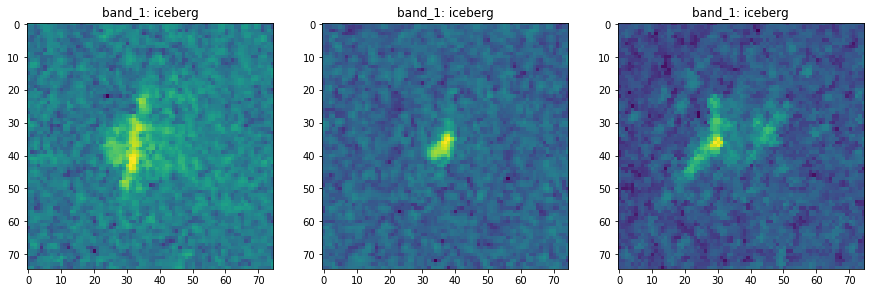

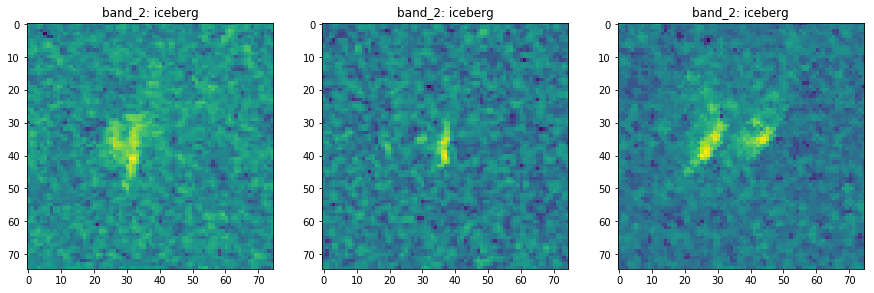

In [9]:
plot_bands(iceberg_samples)


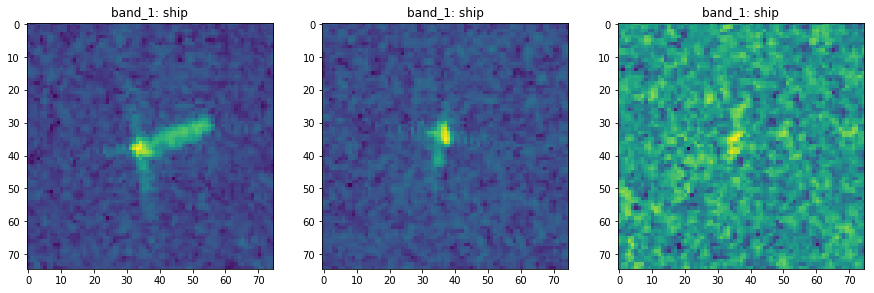

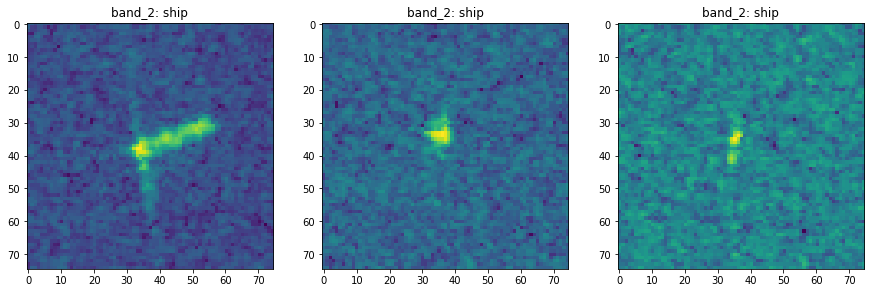

In [10]:
plot_bands(ships_samples)

As we can see, in some examples it's hard to tell if it's a ship or an iceberg.

# Data Preprocessing

## Handling missing values

In [11]:
missing_values = (train['inc_angle'] == 'na').sum()
percentage = missing_values*100/len(train)
print("Number of missing values in 'inc_angle':", missing_values)
print("Percentage: {:.2}%:".format(percentage))

Number of missing values in 'inc_angle': 133
Percentage: 8.3%:


As there were 133 missing data in `inc_angle` out of 1604 entris (that is 8.3% of data) where the other columns had no missing values, we will exclude this field.

In [12]:
train.drop(['inc_angle'], axis=1, inplace=True)
# view train data
train.head()

,band_1,band_2,id,is_iceberg
0,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",dfd5f913,0
1,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",e25388fd,0
2,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",58b2aaa0,1
3,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",4cfc3a18,0
4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",271f93f4,0


## Combining Data: Concatenating bands

In [13]:
# Training data
train_band_1 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_1"]])
train_band_2 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_2"]])

train_features = np.concatenate([train_band_1[:, :, :, np.newaxis],
                                 train_band_2[:, :, :, np.newaxis]], axis=-1)
train_target = np.array(train["is_iceberg"])

print("Features shape:", train_features.shape)
print("Target shape:", train_target.shape)

Features shape: (1604, 75, 75, 2)
Target shape: (1604,)


In [14]:
# Testing data
test_band_1 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_1"]])
test_band_2 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_2"]])

test_features = np.concatenate([test_band_1[:, :, :, np.newaxis],
                                test_band_2[:, :, :, np.newaxis]], axis=-1)
print("Features shape:", test_features.shape)

Features shape: (8424, 75, 75, 2)


# Dimensionality Reduction With PCA

In [15]:
scaler = StandardScaler()
images_scaled = scaler.fit_transform([i.flatten() for i in train_features])

pca = PCA(n_components=50)
pca_result = pca.fit_transform(images_scaled)

In [16]:
reduced_X_train, reduced_X_test, reduced_y_train, reduced_y_test = train_test_split(pca_result,
                                                                train_target, 
                                                                test_size=0.25, 
                                                                random_state=42)


 # Using (RandomForest, K-NN, Logistic Regression)

## Using Random Forest Classifier

In [17]:
forest = RandomForestClassifier(n_estimators=50)
forest = forest.fit(reduced_X_train, reduced_y_train)

## Making Predctions
test_predictions = forest.predict(reduced_X_test)
precision = accuracy_score(test_predictions, reduced_y_test) * 100
print("Accuracy with Random Forest: {0:.4f}".format(precision))

Accuracy with Random Forest: 78.0549


## Using K-NN

In [18]:
knn = KNeighborsClassifier(n_neighbors=20)
knn = knn.fit(reduced_X_train, reduced_y_train)

## Making Predctions
test_predictions = knn.predict(reduced_X_test)
precision = accuracy_score(test_predictions, reduced_y_test) * 100
print("Accuracy with K-NN: {0:.4f}".format(precision))

Accuracy with K-NN: 72.8180


## Using Logistic Regression

In [19]:
lr = LogisticRegression(random_state=20, solver='lbfgs')
lr = lr.fit(reduced_X_train, reduced_y_train)

## Making Predctions
test_predictions = lr.predict(reduced_X_test)
precision = accuracy_score(test_predictions, reduced_y_test) * 100
print("Accuracy with Logistic Regression: {0:.4f}".format(precision))

Accuracy with Logistic Regression: 72.3192


ِAs we can see, the previous methods don't result more than 79% accuracy.

## Split Data ( training data)

In [53]:
X_train, X_test, y_train, y_test = train_test_split(train_features,
                                                    train_target,
                                                    test_size=0.25,
                                                    random_state=7)

print("Total size of dataset:", len(train_features))
print("Size of training set:", len(X_train))
print("Size of testing set:", len(X_test))


Total size of dataset: 1604
Size of training set: 1203
Size of testing set: 401


# Benchmark Model

In [54]:
# define parameters
input_shape = X_train[0].shape

def get_basic_model(input_shape=(75, 75, 2)):
    # Model Archeticture
    basic_model = Sequential()
    # Input layer
    basic_model.add(Conv2D(32, 3, activation="relu", input_shape=input_shape))
    basic_model.add(Conv2D(64, 3, activation="relu"))
    basic_model.add(GlobalAveragePooling2D())
    basic_model.add(Dropout(0.3))
    # output layer
    basic_model.add(Dense(1, activation="sigmoid"))
    return basic_model

basic_model = get_basic_model()
# print model summary
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'training samples')
basic_model.summary()


X_train shape: (1203, 75, 75, 2)
1203 training samples
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 73, 73, 32)        608       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
global_average_pooling2d_2 ( (None, 64)                0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 19,169
Trainable params: 19,169
Non-trainable params: 0
_________________________________________________________________


## Compile model

In [55]:
# compiling model with binary_crossentropy loss function
basic_model.compile("adam", "binary_crossentropy", metrics=["accuracy"])

## Calculate the Classification Accuracy on the Test Set (Before Training)

In [56]:
# evaluate test accuracy
def print_accuracy(model, test_features=X_test, test_target=y_test):
    score = model.evaluate(test_features, test_target, verbose=0)
    accuracy = 100*score[1]
    # print test accuracy
    print('Test accuracy: %.4f%%' % accuracy)
    print('Test loss: {:0.4}'.format(score[0]))


In [57]:
print_accuracy(basic_model)

Test accuracy: 48.3791%
Test loss: 0.7212


## Model Training (model 1)

In [58]:
# train the model
def train_with_kfold(model, checkpoint_path,epochs=50, K=4,batch_size=None):
    history = None
    folds = list(StratifiedKFold(n_splits=K, shuffle=True, random_state=7).split(X_train, y_train))
    for i, (train_index, test_index) in enumerate(folds):
        print('\nFOLD:',i+1)
        # saving each fold's results (weights) as its own checkpoint 
        checkpointer = ModelCheckpoint(filepath= str(i+1)+ "_" + checkpoint_path,
                               verbose=1, save_best_only=True)
        # getting data folds
        X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
        y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
        h = model.fit(X_train_fold, y_train_fold,
                                   epochs=epochs,
                                   validation_data=(X_test_fold, y_test_fold),
                                   callbacks=[checkpointer],
                                   shuffle=True,
                                   batch_size=batch_size)
        # concatenating model histories over subsequent folds
        if history is None:
            history = h
        else:
            history.history['acc'].extend(h.history['acc'])
            history.history['val_acc'].extend(h.history['val_acc'])
            history.history['loss'].extend(h.history['loss'])
            history.history['val_loss'].extend(h.history['val_loss'])
    
    return history


In [59]:
# train model
history_1 = train_with_kfold(basic_model, 'basic.model.best.hdf5', epochs=150, K=2)


FOLD: 1
Train on 601 samples, validate on 602 samples
Epoch 1/150
601/601 [==============================] - 1s 2ms/step - loss: 0.9728 - acc: 0.5225 - val_loss: 0.7261 - val_acc: 0.4967

Epoch 00001: val_loss improved from inf to 0.72614, saving model to 1_basic.model.best.hdf5
Epoch 2/150
601/601 [==============================] - 1s 1ms/step - loss: 0.6978 - acc: 0.5391 - val_loss: 0.6357 - val_acc: 0.5797

Epoch 00002: val_loss improved from 0.72614 to 0.63567, saving model to 1_basic.model.best.hdf5
Epoch 3/150
601/601 [==============================] - 1s 994us/step - loss: 0.6370 - acc: 0.5940 - val_loss: 0.6111 - val_acc: 0.6445

Epoch 00003: val_loss improved from 0.63567 to 0.61114, saving model to 1_basic.model.best.hdf5
Epoch 4/150
601/601 [==============================] - 1s 992us/step - loss: 0.6141 - acc: 0.6389 - val_loss: 0.5944 - val_acc: 0.6578

Epoch 00004: val_loss improved from 0.61114 to 0.59443, saving model to 1_basic.model.best.hdf5
Epoch 5/150
601/601 [====

601/601 [==============================] - 1s 991us/step - loss: 0.4949 - acc: 0.7537 - val_loss: 0.4923 - val_acc: 0.7425

Epoch 00038: val_loss did not improve from 0.49145
Epoch 39/150
601/601 [==============================] - 1s 1ms/step - loss: 0.4853 - acc: 0.7571 - val_loss: 0.4883 - val_acc: 0.7425

Epoch 00039: val_loss improved from 0.49145 to 0.48832, saving model to 1_basic.model.best.hdf5
Epoch 40/150
601/601 [==============================] - 1s 996us/step - loss: 0.4920 - acc: 0.7571 - val_loss: 0.4959 - val_acc: 0.7525

Epoch 00040: val_loss did not improve from 0.48832
Epoch 41/150
601/601 [==============================] - 1s 993us/step - loss: 0.4897 - acc: 0.7537 - val_loss: 0.4857 - val_acc: 0.7442

Epoch 00041: val_loss improved from 0.48832 to 0.48568, saving model to 1_basic.model.best.hdf5
Epoch 42/150
601/601 [==============================] - 1s 988us/step - loss: 0.4849 - acc: 0.7637 - val_loss: 0.4863 - val_acc: 0.7475

Epoch 00042: val_loss did not improv

601/601 [==============================] - 1s 994us/step - loss: 0.4090 - acc: 0.8120 - val_loss: 0.4179 - val_acc: 0.7874

Epoch 00117: val_loss did not improve from 0.40670
Epoch 118/150
601/601 [==============================] - 1s 1ms/step - loss: 0.4061 - acc: 0.8253 - val_loss: 0.4039 - val_acc: 0.7940

Epoch 00118: val_loss improved from 0.40670 to 0.40387, saving model to 1_basic.model.best.hdf5
Epoch 119/150
601/601 [==============================] - 1s 994us/step - loss: 0.4013 - acc: 0.8220 - val_loss: 0.4047 - val_acc: 0.7973

Epoch 00119: val_loss did not improve from 0.40387
Epoch 120/150
601/601 [==============================] - 1s 999us/step - loss: 0.3884 - acc: 0.8087 - val_loss: 0.4029 - val_acc: 0.7924

Epoch 00120: val_loss improved from 0.40387 to 0.40292, saving model to 1_basic.model.best.hdf5
Epoch 121/150
601/601 [==============================] - 1s 1ms/step - loss: 0.3976 - acc: 0.8186 - val_loss: 0.4059 - val_acc: 0.7924

Epoch 00121: val_loss did not impr

602/602 [==============================] - 1s 993us/step - loss: 0.3651 - acc: 0.8056 - val_loss: 0.3409 - val_acc: 0.8386

Epoch 00049: val_loss did not improve from 0.33805
Epoch 50/150
602/602 [==============================] - 1s 997us/step - loss: 0.3574 - acc: 0.8156 - val_loss: 0.3417 - val_acc: 0.8319

Epoch 00050: val_loss did not improve from 0.33805
Epoch 51/150
602/602 [==============================] - 1s 1ms/step - loss: 0.3463 - acc: 0.8206 - val_loss: 0.3487 - val_acc: 0.8436

Epoch 00051: val_loss did not improve from 0.33805
Epoch 52/150
602/602 [==============================] - 1s 1000us/step - loss: 0.3737 - acc: 0.8056 - val_loss: 0.3521 - val_acc: 0.8203

Epoch 00052: val_loss did not improve from 0.33805
Epoch 53/150
602/602 [==============================] - 1s 996us/step - loss: 0.3747 - acc: 0.8090 - val_loss: 0.3477 - val_acc: 0.8369

Epoch 00053: val_loss did not improve from 0.33805
Epoch 54/150
602/602 [==============================] - 1s 999us/step - lo


Epoch 00091: val_loss did not improve from 0.33166
Epoch 92/150
602/602 [==============================] - 1s 991us/step - loss: 0.3432 - acc: 0.8306 - val_loss: 0.3273 - val_acc: 0.8486

Epoch 00092: val_loss improved from 0.33166 to 0.32725, saving model to 2_basic.model.best.hdf5
Epoch 93/150
602/602 [==============================] - 1s 993us/step - loss: 0.3543 - acc: 0.8256 - val_loss: 0.3456 - val_acc: 0.8486

Epoch 00093: val_loss did not improve from 0.32725
Epoch 94/150
602/602 [==============================] - 1s 992us/step - loss: 0.3609 - acc: 0.8189 - val_loss: 0.3458 - val_acc: 0.8303

Epoch 00094: val_loss did not improve from 0.32725
Epoch 95/150
602/602 [==============================] - 1s 1ms/step - loss: 0.3503 - acc: 0.8272 - val_loss: 0.3279 - val_acc: 0.8403

Epoch 00095: val_loss did not improve from 0.32725
Epoch 96/150
602/602 [==============================] - 1s 999us/step - loss: 0.3493 - acc: 0.8239 - val_loss: 0.3331 - val_acc: 0.8636

Epoch 00096: val

602/602 [==============================] - 1s 995us/step - loss: 0.3382 - acc: 0.8422 - val_loss: 0.3204 - val_acc: 0.8602

Epoch 00134: val_loss did not improve from 0.31873
Epoch 135/150
602/602 [==============================] - 1s 1ms/step - loss: 0.3406 - acc: 0.8239 - val_loss: 0.3187 - val_acc: 0.8569

Epoch 00135: val_loss improved from 0.31873 to 0.31866, saving model to 2_basic.model.best.hdf5
Epoch 136/150
602/602 [==============================] - 1s 989us/step - loss: 0.3288 - acc: 0.8339 - val_loss: 0.3290 - val_acc: 0.8785

Epoch 00136: val_loss did not improve from 0.31866
Epoch 137/150
602/602 [==============================] - 1s 998us/step - loss: 0.3458 - acc: 0.8322 - val_loss: 0.3165 - val_acc: 0.8569

Epoch 00137: val_loss improved from 0.31866 to 0.31645, saving model to 2_basic.model.best.hdf5
Epoch 138/150
602/602 [==============================] - 1s 997us/step - loss: 0.3392 - acc: 0.8339 - val_loss: 0.3302 - val_acc: 0.8835

Epoch 00138: val_loss did not im

## Model Evaluation (model 1)

### Calculate the Classification Accuracy on the Test Set

In [60]:
print("Fold 1")
basic_model.load_weights('1_basic.model.best.hdf5')
print_accuracy(basic_model)
print("\nFold 2")
basic_model.load_weights('2_basic.model.best.hdf5')
print_accuracy(basic_model)

Fold 1
Test accuracy: 81.2968%
Test loss: 0.3737

Fold 2
Test accuracy: 84.2893%
Test loss: 0.3083


In [61]:
# load best weights
basic_model.load_weights('2_basic.model.best.hdf5')

### Confusion Matrix

In [62]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        pass#print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



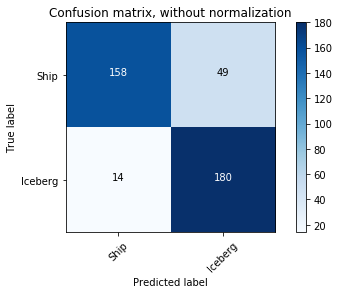

In [63]:
# get predictions
y_pred = basic_model.predict(X_test)
func = lambda x: 1 if x >= 0.5 else 0
y_pred_classes = np.array(list(map(func, y_pred)))
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_classes)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=classes,
                      title='Confusion matrix, without normalization')



### Classification Report

In [64]:
print(classification_report(y_test, y_pred_classes, target_names=classes))

              precision    recall  f1-score   support

        Ship       0.92      0.76      0.83       207
     Iceberg       0.79      0.93      0.85       194

   micro avg       0.84      0.84      0.84       401
   macro avg       0.85      0.85      0.84       401
weighted avg       0.85      0.84      0.84       401



### Model History

In [65]:
def plot_history(history):
    # list all data in history
    #print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()


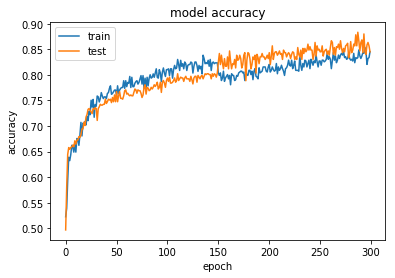

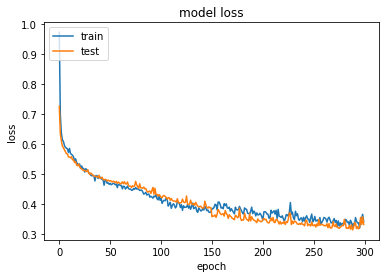

In [66]:
plot_history(history_1)

# Refining Basic Model

In [223]:
refined_model = get_basic_model()
refined_model.compile("adam", "binary_crossentropy", metrics=["accuracy"])
# train model
history_1_V2 = train_with_kfold(refined_model, 'refined.model.best.hdf5', epochs=250, K=4)



FOLD: 1
Train on 902 samples, validate on 301 samples
Epoch 1/250
902/902 [==============================] - 2s 2ms/step - loss: 0.8826 - acc: 0.5133 - val_loss: 0.6560 - val_acc: 0.6545

Epoch 00001: val_loss improved from inf to 0.65600, saving model to 1_refined.model.best.hdf5
Epoch 2/250
902/902 [==============================] - 1s 841us/step - loss: 0.6353 - acc: 0.5976 - val_loss: 0.5970 - val_acc: 0.6412

Epoch 00002: val_loss improved from 0.65600 to 0.59700, saving model to 1_refined.model.best.hdf5
Epoch 3/250
902/902 [==============================] - 1s 837us/step - loss: 0.5937 - acc: 0.6530 - val_loss: 0.6963 - val_acc: 0.5349

Epoch 00003: val_loss did not improve from 0.59700
Epoch 4/250
902/902 [==============================] - 1s 842us/step - loss: 0.6106 - acc: 0.6208 - val_loss: 0.5854 - val_acc: 0.5116

Epoch 00004: val_loss improved from 0.59700 to 0.58540, saving model to 1_refined.model.best.hdf5
Epoch 5/250
902/902 [==============================] - 1s 837u


Epoch 00037: val_loss did not improve from 0.47089
Epoch 38/250
902/902 [==============================] - 1s 844us/step - loss: 0.4775 - acc: 0.7561 - val_loss: 0.4684 - val_acc: 0.7807

Epoch 00038: val_loss improved from 0.47089 to 0.46837, saving model to 1_refined.model.best.hdf5
Epoch 39/250
902/902 [==============================] - 1s 847us/step - loss: 0.4805 - acc: 0.7583 - val_loss: 0.4674 - val_acc: 0.7874

Epoch 00039: val_loss improved from 0.46837 to 0.46744, saving model to 1_refined.model.best.hdf5
Epoch 40/250
902/902 [==============================] - 1s 840us/step - loss: 0.4802 - acc: 0.7550 - val_loss: 0.4650 - val_acc: 0.7807

Epoch 00040: val_loss improved from 0.46744 to 0.46502, saving model to 1_refined.model.best.hdf5
Epoch 41/250
902/902 [==============================] - 1s 841us/step - loss: 0.4767 - acc: 0.7561 - val_loss: 0.4682 - val_acc: 0.7841

Epoch 00041: val_loss did not improve from 0.46502
Epoch 42/250
902/902 [==============================] -

902/902 [==============================] - 1s 839us/step - loss: 0.4462 - acc: 0.7860 - val_loss: 0.4271 - val_acc: 0.7907

Epoch 00078: val_loss did not improve from 0.41619
Epoch 79/250
902/902 [==============================] - 1s 840us/step - loss: 0.4429 - acc: 0.7838 - val_loss: 0.4383 - val_acc: 0.7907

Epoch 00079: val_loss did not improve from 0.41619
Epoch 80/250
902/902 [==============================] - 1s 838us/step - loss: 0.4380 - acc: 0.7816 - val_loss: 0.4271 - val_acc: 0.7907

Epoch 00080: val_loss did not improve from 0.41619
Epoch 81/250
902/902 [==============================] - 1s 842us/step - loss: 0.4285 - acc: 0.7927 - val_loss: 0.4201 - val_acc: 0.8007

Epoch 00081: val_loss did not improve from 0.41619
Epoch 82/250
902/902 [==============================] - 1s 844us/step - loss: 0.4358 - acc: 0.7827 - val_loss: 0.4274 - val_acc: 0.7973

Epoch 00082: val_loss did not improve from 0.41619
Epoch 83/250
902/902 [==============================] - 1s 842us/step - l

902/902 [==============================] - 1s 839us/step - loss: 0.4083 - acc: 0.7916 - val_loss: 0.3843 - val_acc: 0.8173

Epoch 00119: val_loss improved from 0.38497 to 0.38429, saving model to 1_refined.model.best.hdf5
Epoch 120/250
902/902 [==============================] - 1s 844us/step - loss: 0.4022 - acc: 0.7827 - val_loss: 0.4194 - val_acc: 0.7907

Epoch 00120: val_loss did not improve from 0.38429
Epoch 121/250
902/902 [==============================] - 1s 839us/step - loss: 0.4143 - acc: 0.7993 - val_loss: 0.3910 - val_acc: 0.8206

Epoch 00121: val_loss did not improve from 0.38429
Epoch 122/250
902/902 [==============================] - 1s 846us/step - loss: 0.3955 - acc: 0.8093 - val_loss: 0.3991 - val_acc: 0.8106

Epoch 00122: val_loss did not improve from 0.38429
Epoch 123/250
902/902 [==============================] - 1s 837us/step - loss: 0.3991 - acc: 0.8093 - val_loss: 0.3898 - val_acc: 0.8140

Epoch 00123: val_loss did not improve from 0.38429
Epoch 124/250
902/902 

902/902 [==============================] - 1s 838us/step - loss: 0.3635 - acc: 0.8248 - val_loss: 0.3558 - val_acc: 0.8239

Epoch 00201: val_loss did not improve from 0.34464
Epoch 202/250
902/902 [==============================] - 1s 838us/step - loss: 0.3559 - acc: 0.8082 - val_loss: 0.3891 - val_acc: 0.7874

Epoch 00202: val_loss did not improve from 0.34464
Epoch 203/250
902/902 [==============================] - 1s 838us/step - loss: 0.3508 - acc: 0.8448 - val_loss: 0.3507 - val_acc: 0.8239

Epoch 00203: val_loss did not improve from 0.34464
Epoch 204/250
902/902 [==============================] - 1s 840us/step - loss: 0.3495 - acc: 0.8304 - val_loss: 0.3480 - val_acc: 0.8239

Epoch 00204: val_loss did not improve from 0.34464
Epoch 205/250
902/902 [==============================] - 1s 839us/step - loss: 0.3475 - acc: 0.8337 - val_loss: 0.3552 - val_acc: 0.8239

Epoch 00205: val_loss did not improve from 0.34464
Epoch 206/250
902/902 [==============================] - 1s 847us/ste


Epoch 00243: val_loss did not improve from 0.32643
Epoch 244/250
902/902 [==============================] - 1s 840us/step - loss: 0.3239 - acc: 0.8481 - val_loss: 0.3650 - val_acc: 0.8040

Epoch 00244: val_loss did not improve from 0.32643
Epoch 245/250
902/902 [==============================] - 1s 843us/step - loss: 0.3264 - acc: 0.8492 - val_loss: 0.3368 - val_acc: 0.8206

Epoch 00245: val_loss did not improve from 0.32643
Epoch 246/250
902/902 [==============================] - 1s 844us/step - loss: 0.3369 - acc: 0.8481 - val_loss: 0.3685 - val_acc: 0.8007

Epoch 00246: val_loss did not improve from 0.32643
Epoch 247/250
902/902 [==============================] - 1s 843us/step - loss: 0.3459 - acc: 0.8237 - val_loss: 0.3620 - val_acc: 0.8040

Epoch 00247: val_loss did not improve from 0.32643
Epoch 248/250
902/902 [==============================] - 1s 845us/step - loss: 0.3271 - acc: 0.8459 - val_loss: 0.3343 - val_acc: 0.8306

Epoch 00248: val_loss did not improve from 0.32643
Epo

902/902 [==============================] - 1s 843us/step - loss: 0.2877 - acc: 0.8636 - val_loss: 0.4171 - val_acc: 0.8106

Epoch 00079: val_loss did not improve from 0.32674
Epoch 80/250
902/902 [==============================] - 1s 844us/step - loss: 0.2986 - acc: 0.8614 - val_loss: 0.3316 - val_acc: 0.8206

Epoch 00080: val_loss did not improve from 0.32674
Epoch 81/250
902/902 [==============================] - 1s 848us/step - loss: 0.2949 - acc: 0.8537 - val_loss: 0.3261 - val_acc: 0.8439

Epoch 00081: val_loss improved from 0.32674 to 0.32609, saving model to 2_refined.model.best.hdf5
Epoch 82/250
902/902 [==============================] - 1s 843us/step - loss: 0.2950 - acc: 0.8559 - val_loss: 0.3330 - val_acc: 0.8538

Epoch 00082: val_loss did not improve from 0.32609
Epoch 83/250
902/902 [==============================] - 1s 841us/step - loss: 0.2929 - acc: 0.8625 - val_loss: 0.3595 - val_acc: 0.8439

Epoch 00083: val_loss did not improve from 0.32609
Epoch 84/250
902/902 [====

902/902 [==============================] - 1s 837us/step - loss: 0.2734 - acc: 0.8703 - val_loss: 0.3537 - val_acc: 0.8439

Epoch 00122: val_loss did not improve from 0.32272
Epoch 123/250
902/902 [==============================] - 1s 843us/step - loss: 0.2803 - acc: 0.8659 - val_loss: 0.3428 - val_acc: 0.8505

Epoch 00123: val_loss did not improve from 0.32272
Epoch 124/250
902/902 [==============================] - 1s 838us/step - loss: 0.2728 - acc: 0.8703 - val_loss: 0.3426 - val_acc: 0.8638

Epoch 00124: val_loss did not improve from 0.32272
Epoch 125/250
902/902 [==============================] - 1s 836us/step - loss: 0.3141 - acc: 0.8514 - val_loss: 0.3674 - val_acc: 0.8439

Epoch 00125: val_loss did not improve from 0.32272
Epoch 126/250
902/902 [==============================] - 1s 841us/step - loss: 0.2858 - acc: 0.8725 - val_loss: 0.3300 - val_acc: 0.8571

Epoch 00126: val_loss did not improve from 0.32272
Epoch 127/250
902/902 [==============================] - 1s 839us/ste

902/902 [==============================] - 1s 842us/step - loss: 0.2718 - acc: 0.8780 - val_loss: 0.3388 - val_acc: 0.8571

Epoch 00207: val_loss did not improve from 0.30563
Epoch 208/250
902/902 [==============================] - 1s 839us/step - loss: 0.2529 - acc: 0.8925 - val_loss: 0.3096 - val_acc: 0.8638

Epoch 00208: val_loss did not improve from 0.30563
Epoch 209/250
902/902 [==============================] - 1s 839us/step - loss: 0.2515 - acc: 0.8847 - val_loss: 0.3666 - val_acc: 0.8073

Epoch 00209: val_loss did not improve from 0.30563
Epoch 210/250
902/902 [==============================] - 1s 842us/step - loss: 0.2875 - acc: 0.8614 - val_loss: 0.3199 - val_acc: 0.8571

Epoch 00210: val_loss did not improve from 0.30563
Epoch 211/250
902/902 [==============================] - 1s 838us/step - loss: 0.2551 - acc: 0.8847 - val_loss: 0.3267 - val_acc: 0.8505

Epoch 00211: val_loss did not improve from 0.30563
Epoch 212/250
902/902 [==============================] - 1s 845us/ste

902/902 [==============================] - 1s 836us/step - loss: 0.2636 - acc: 0.8880 - val_loss: 0.3120 - val_acc: 0.8605

Epoch 00042: val_loss did not improve from 0.25223
Epoch 43/250
902/902 [==============================] - 1s 838us/step - loss: 0.3025 - acc: 0.8692 - val_loss: 0.2927 - val_acc: 0.8771

Epoch 00043: val_loss did not improve from 0.25223
Epoch 44/250
902/902 [==============================] - 1s 843us/step - loss: 0.2593 - acc: 0.8847 - val_loss: 0.2600 - val_acc: 0.8837

Epoch 00044: val_loss did not improve from 0.25223
Epoch 45/250
902/902 [==============================] - 1s 841us/step - loss: 0.2573 - acc: 0.8858 - val_loss: 0.2630 - val_acc: 0.8771

Epoch 00045: val_loss did not improve from 0.25223
Epoch 46/250
902/902 [==============================] - 1s 842us/step - loss: 0.2598 - acc: 0.8836 - val_loss: 0.2744 - val_acc: 0.8704

Epoch 00046: val_loss did not improve from 0.25223
Epoch 47/250
902/902 [==============================] - 1s 845us/step - l


Epoch 00085: val_loss did not improve from 0.25223
Epoch 86/250
902/902 [==============================] - 1s 841us/step - loss: 0.2491 - acc: 0.8936 - val_loss: 0.2795 - val_acc: 0.8771

Epoch 00086: val_loss did not improve from 0.25223
Epoch 87/250
902/902 [==============================] - 1s 837us/step - loss: 0.2468 - acc: 0.8914 - val_loss: 0.3002 - val_acc: 0.8704

Epoch 00087: val_loss did not improve from 0.25223
Epoch 88/250
902/902 [==============================] - 1s 840us/step - loss: 0.2673 - acc: 0.8714 - val_loss: 0.2713 - val_acc: 0.9003

Epoch 00088: val_loss did not improve from 0.25223
Epoch 89/250
902/902 [==============================] - 1s 839us/step - loss: 0.2521 - acc: 0.8947 - val_loss: 0.2656 - val_acc: 0.8837

Epoch 00089: val_loss did not improve from 0.25223
Epoch 90/250
902/902 [==============================] - 1s 842us/step - loss: 0.2579 - acc: 0.8814 - val_loss: 0.2717 - val_acc: 0.8904

Epoch 00090: val_loss did not improve from 0.25223
Epoch 91

902/902 [==============================] - 1s 843us/step - loss: 0.2614 - acc: 0.8836 - val_loss: 0.3035 - val_acc: 0.8571

Epoch 00172: val_loss did not improve from 0.25223
Epoch 173/250
902/902 [==============================] - 1s 839us/step - loss: 0.2429 - acc: 0.8969 - val_loss: 0.2818 - val_acc: 0.8704

Epoch 00173: val_loss did not improve from 0.25223
Epoch 174/250
902/902 [==============================] - 1s 842us/step - loss: 0.2370 - acc: 0.8825 - val_loss: 0.2703 - val_acc: 0.8837

Epoch 00174: val_loss did not improve from 0.25223
Epoch 175/250
902/902 [==============================] - 1s 843us/step - loss: 0.2268 - acc: 0.9047 - val_loss: 0.2805 - val_acc: 0.8837

Epoch 00175: val_loss did not improve from 0.25223
Epoch 176/250
902/902 [==============================] - 1s 836us/step - loss: 0.2463 - acc: 0.8947 - val_loss: 0.2740 - val_acc: 0.8937

Epoch 00176: val_loss did not improve from 0.25223
Epoch 177/250
902/902 [==============================] - 1s 841us/ste

903/903 [==============================] - 1s 840us/step - loss: 0.2729 - acc: 0.8704 - val_loss: 0.1853 - val_acc: 0.9467

Epoch 00008: val_loss did not improve from 0.16392
Epoch 9/250
903/903 [==============================] - 1s 840us/step - loss: 0.2537 - acc: 0.8815 - val_loss: 0.1697 - val_acc: 0.9367

Epoch 00009: val_loss did not improve from 0.16392
Epoch 10/250
903/903 [==============================] - 1s 839us/step - loss: 0.2545 - acc: 0.8893 - val_loss: 0.1813 - val_acc: 0.9333

Epoch 00010: val_loss did not improve from 0.16392
Epoch 11/250
903/903 [==============================] - 1s 840us/step - loss: 0.2537 - acc: 0.8893 - val_loss: 0.1985 - val_acc: 0.9167

Epoch 00011: val_loss did not improve from 0.16392
Epoch 12/250
903/903 [==============================] - 1s 840us/step - loss: 0.2693 - acc: 0.8859 - val_loss: 0.1897 - val_acc: 0.9333

Epoch 00012: val_loss did not improve from 0.16392
Epoch 13/250
903/903 [==============================] - 1s 840us/step - lo


Epoch 00051: val_loss did not improve from 0.16392
Epoch 52/250
903/903 [==============================] - 1s 840us/step - loss: 0.2463 - acc: 0.8859 - val_loss: 0.1764 - val_acc: 0.9300

Epoch 00052: val_loss did not improve from 0.16392
Epoch 53/250
903/903 [==============================] - 1s 838us/step - loss: 0.2501 - acc: 0.8815 - val_loss: 0.1981 - val_acc: 0.9233

Epoch 00053: val_loss did not improve from 0.16392
Epoch 54/250
903/903 [==============================] - 1s 840us/step - loss: 0.2358 - acc: 0.8970 - val_loss: 0.1693 - val_acc: 0.9400

Epoch 00054: val_loss did not improve from 0.16392
Epoch 55/250
903/903 [==============================] - 1s 845us/step - loss: 0.2427 - acc: 0.8915 - val_loss: 0.1714 - val_acc: 0.9433

Epoch 00055: val_loss did not improve from 0.16392
Epoch 56/250
903/903 [==============================] - 1s 848us/step - loss: 0.2378 - acc: 0.8926 - val_loss: 0.1828 - val_acc: 0.9267

Epoch 00056: val_loss did not improve from 0.16392
Epoch 57

903/903 [==============================] - 1s 841us/step - loss: 0.2347 - acc: 0.9014 - val_loss: 0.1827 - val_acc: 0.9367

Epoch 00138: val_loss did not improve from 0.16392
Epoch 139/250
903/903 [==============================] - 1s 839us/step - loss: 0.2535 - acc: 0.8859 - val_loss: 0.1756 - val_acc: 0.9467

Epoch 00139: val_loss did not improve from 0.16392
Epoch 140/250
903/903 [==============================] - 1s 842us/step - loss: 0.2245 - acc: 0.9125 - val_loss: 0.1871 - val_acc: 0.9167

Epoch 00140: val_loss did not improve from 0.16392
Epoch 141/250
903/903 [==============================] - 1s 846us/step - loss: 0.2406 - acc: 0.8948 - val_loss: 0.1814 - val_acc: 0.9333

Epoch 00141: val_loss did not improve from 0.16392
Epoch 142/250
903/903 [==============================] - 1s 841us/step - loss: 0.2383 - acc: 0.8948 - val_loss: 0.1708 - val_acc: 0.9433

Epoch 00142: val_loss did not improve from 0.16392
Epoch 143/250
903/903 [==============================] - 1s 840us/ste

903/903 [==============================] - 1s 848us/step - loss: 0.2198 - acc: 0.9147 - val_loss: 0.1788 - val_acc: 0.9200

Epoch 00224: val_loss did not improve from 0.16392
Epoch 225/250
903/903 [==============================] - 1s 842us/step - loss: 0.2140 - acc: 0.9048 - val_loss: 0.1899 - val_acc: 0.9233

Epoch 00225: val_loss did not improve from 0.16392
Epoch 226/250
903/903 [==============================] - 1s 840us/step - loss: 0.2116 - acc: 0.9114 - val_loss: 0.1911 - val_acc: 0.9300

Epoch 00226: val_loss did not improve from 0.16392
Epoch 227/250
903/903 [==============================] - 1s 841us/step - loss: 0.2227 - acc: 0.9070 - val_loss: 0.1653 - val_acc: 0.9400

Epoch 00227: val_loss did not improve from 0.16392
Epoch 228/250
903/903 [==============================] - 1s 837us/step - loss: 0.2367 - acc: 0.9125 - val_loss: 0.2000 - val_acc: 0.9267

Epoch 00228: val_loss did not improve from 0.16392
Epoch 229/250
903/903 [==============================] - 1s 839us/ste

## Model Evaluation

In [253]:
print("Fold 1")
refined_model.load_weights('1_refined.model.best.hdf5')
print_accuracy(refined_model)
print("\nFold 2")
refined_model.load_weights('2_refined.model.best.hdf5')
print_accuracy(refined_model)
print("\nFold 3")
refined_model.load_weights('3_refined.model.best.hdf5')
print_accuracy(refined_model)
print("\nFold 4")
refined_model.load_weights('4_refined.model.best.hdf5')
print_accuracy(refined_model)

Fold 1
Test accuracy: 83.7905%
Test loss: 0.3215

Fold 2
Test accuracy: 87.7805%
Test loss: 0.2706

Fold 3
Test accuracy: 89.5262%
Test loss: 0.2765

Fold 4
Test accuracy: 90.7731%
Test loss: 0.2643


In [225]:
# load best weights
refined_model.load_weights('4_refined.model.best.hdf5')

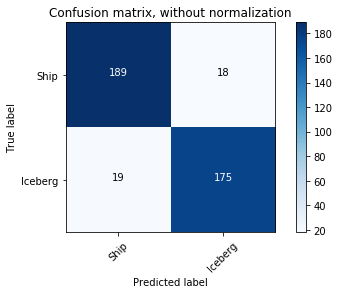

In [226]:
# get predictions
y_pred = refined_model.predict(X_test)
func = lambda x: 1 if x >= 0.5 else 0
y_pred_classes = np.array(list(map(func, y_pred)))
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_classes)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=classes,
                      title='Confusion matrix, without normalization')



In [227]:
print(classification_report(y_test, y_pred_classes, target_names=classes))

              precision    recall  f1-score   support

        Ship       0.91      0.91      0.91       207
     Iceberg       0.91      0.90      0.90       194

   micro avg       0.91      0.91      0.91       401
   macro avg       0.91      0.91      0.91       401
weighted avg       0.91      0.91      0.91       401



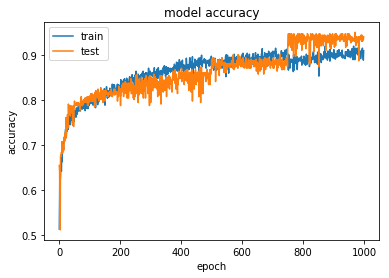

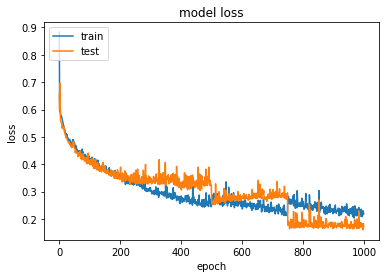

In [228]:
plot_history(history_1_V2)

# Improved Model

In [229]:
def get_improved_model(input_shape=(75,75,2)):
    # create the model and define the architecture.
    improved_model = Sequential()
    #
    improved_model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same',
                             activation='relu', input_shape=input_shape))
    improved_model.add(MaxPooling2D(pool_size=2))
    
    improved_model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu'))
    improved_model.add(MaxPooling2D(pool_size=2))
    
    improved_model.add(Conv2D(filters=256, kernel_size=2, padding='same', activation='relu'))
    improved_model.add(MaxPooling2D(pool_size=2))
    
    improved_model.add(Conv2D(filters=512, kernel_size=2, padding='same', activation='relu'))
    improved_model.add(MaxPooling2D(pool_size=2))
    
    improved_model.add(Dropout(0.3))
    improved_model.add(Flatten())
    improved_model.add(Dropout(0.5))
    # output layer
    improved_model.add(Dense(1, activation='sigmoid'))
    return improved_model

improved_model = get_improved_model()

# print model summary
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'training samples')
improved_model.summary()

X_train shape: (1203, 75, 75, 2)
1203 training samples
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 75, 75, 64)        1216      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 37, 37, 128)       32896     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 18, 18, 128)       0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 18, 18, 256)       131328    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 9, 9, 256)         0         
_________________________________________________________________
conv2d_26 (Conv2D)   

## Compile model

In [230]:
# compiling model with binary_crossentropy loss function
optimizer = Adam(lr=1e-4)
improved_model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

## Calculate the Classification Accuracy on the Test Set (Before Training)

In [231]:
# evaluate test accuracy
print_accuracy(improved_model)

Test accuracy: 48.3791%
Test loss: 1.627


## Model Training (model 2)

In [232]:
# train the model
history_2 = train_with_kfold(improved_model, 'improved.model.best.hdf5', epochs=50, K=3)


FOLD: 1
Train on 801 samples, validate on 402 samples
Epoch 1/50
801/801 [==============================] - 2s 3ms/step - loss: 1.0287 - acc: 0.5231 - val_loss: 0.7409 - val_acc: 0.5970

Epoch 00001: val_loss improved from inf to 0.74088, saving model to 1_improved.model.best.hdf5
Epoch 2/50
801/801 [==============================] - 1s 1ms/step - loss: 0.7712 - acc: 0.5843 - val_loss: 0.5842 - val_acc: 0.6443

Epoch 00002: val_loss improved from 0.74088 to 0.58423, saving model to 1_improved.model.best.hdf5
Epoch 3/50
801/801 [==============================] - 1s 1ms/step - loss: 0.6546 - acc: 0.6017 - val_loss: 0.5649 - val_acc: 0.6692

Epoch 00003: val_loss improved from 0.58423 to 0.56494, saving model to 1_improved.model.best.hdf5
Epoch 4/50
801/801 [==============================] - 1s 1ms/step - loss: 0.5814 - acc: 0.6617 - val_loss: 0.5456 - val_acc: 0.6741

Epoch 00004: val_loss improved from 0.56494 to 0.54563, saving model to 1_improved.model.best.hdf5
Epoch 5/50
801/801 [=

802/802 [==============================] - 1s 1ms/step - loss: 0.1154 - acc: 0.9564 - val_loss: 0.1590 - val_acc: 0.9352

Epoch 00030: val_loss did not improve from 0.14565
Epoch 31/50
802/802 [==============================] - 1s 1ms/step - loss: 0.1056 - acc: 0.9626 - val_loss: 0.1537 - val_acc: 0.9401

Epoch 00031: val_loss did not improve from 0.14565
Epoch 32/50
802/802 [==============================] - 1s 1ms/step - loss: 0.1067 - acc: 0.9638 - val_loss: 0.1684 - val_acc: 0.9377

Epoch 00032: val_loss did not improve from 0.14565
Epoch 33/50
802/802 [==============================] - 1s 1ms/step - loss: 0.1004 - acc: 0.9638 - val_loss: 0.1525 - val_acc: 0.9327

Epoch 00033: val_loss did not improve from 0.14565
Epoch 34/50
802/802 [==============================] - 1s 1ms/step - loss: 0.0978 - acc: 0.9638 - val_loss: 0.1699 - val_acc: 0.9202

Epoch 00034: val_loss did not improve from 0.14565
Epoch 35/50
802/802 [==============================] - 1s 1ms/step - loss: 0.0866 - acc


Epoch 00023: val_loss did not improve from 0.03347
Epoch 24/50
803/803 [==============================] - 1s 1ms/step - loss: 0.0374 - acc: 0.9950 - val_loss: 0.0418 - val_acc: 0.9900

Epoch 00024: val_loss did not improve from 0.03347
Epoch 25/50
803/803 [==============================] - 1s 1ms/step - loss: 0.0356 - acc: 0.9963 - val_loss: 0.0366 - val_acc: 0.9900

Epoch 00025: val_loss did not improve from 0.03347
Epoch 26/50
803/803 [==============================] - 1s 1ms/step - loss: 0.0332 - acc: 0.9925 - val_loss: 0.0336 - val_acc: 0.9875

Epoch 00026: val_loss did not improve from 0.03347
Epoch 27/50
803/803 [==============================] - 1s 1ms/step - loss: 0.0356 - acc: 0.9950 - val_loss: 0.0326 - val_acc: 0.9850

Epoch 00027: val_loss improved from 0.03347 to 0.03261, saving model to 3_improved.model.best.hdf5
Epoch 28/50
803/803 [==============================] - 1s 1ms/step - loss: 0.0271 - acc: 0.9963 - val_loss: 0.0316 - val_acc: 0.9850

Epoch 00028: val_loss impr

## Model Evaluation (model 2)

In [233]:
print("Fold 1")
improved_model.load_weights('1_improved.model.best.hdf5')
print_accuracy(improved_model)
print("\nFold 2")
improved_model.load_weights('2_improved.model.best.hdf5')
print_accuracy(improved_model)
print("\nFold 3")
improved_model.load_weights('3_improved.model.best.hdf5')
print_accuracy(improved_model)

Fold 1
Test accuracy: 87.2818%
Test loss: 0.3031

Fold 2
Test accuracy: 89.2768%
Test loss: 0.2643

Fold 3
Test accuracy: 90.2743%
Test loss: 0.3537


In [254]:
# load best weights
improved_model.load_weights('3_improved.model.best.hdf5')

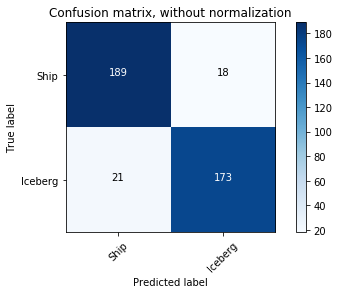

In [255]:
# get predictions
y_pred = improved_model.predict(X_test)
func = lambda x: 1 if x >= 0.5 else 0
y_pred_classes = np.array(list(map(func, y_pred)))
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_classes)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=classes,
                      title='Confusion matrix, without normalization')



In [256]:
print(classification_report(y_test, y_pred_classes, target_names=classes))

              precision    recall  f1-score   support

        Ship       0.90      0.91      0.91       207
     Iceberg       0.91      0.89      0.90       194

   micro avg       0.90      0.90      0.90       401
   macro avg       0.90      0.90      0.90       401
weighted avg       0.90      0.90      0.90       401



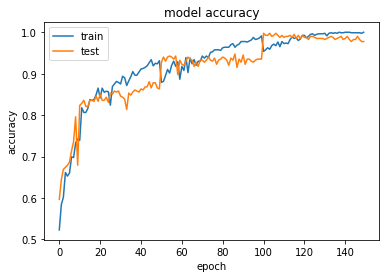

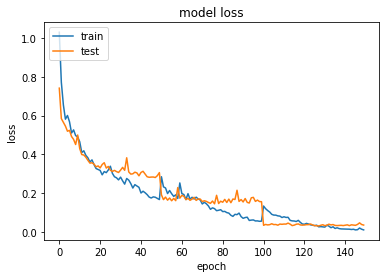

In [237]:
#
plot_history(history_2)

## Best  aquired weights for this model

In [257]:
# load best acquired models
improved_model.load_weights('../input/statoil-model-weights/pretrained.best.hdf5')
# evaluate test accuracy
print_accuracy(improved_model)

Test accuracy: 91.7706%
Test loss: 0.3397


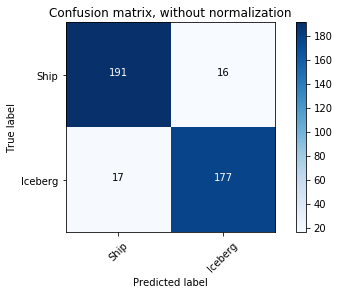

In [258]:
# get predictions
y_pred = improved_model.predict(X_test)
func = lambda x: 1 if x >= 0.5 else 0
y_pred_classes = np.array(list(map(func, y_pred)))
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_classes)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=classes,
                      title='Confusion matrix, without normalization')



In [259]:
print(classification_report(y_test, y_pred_classes, target_names=classes))

              precision    recall  f1-score   support

        Ship       0.92      0.92      0.92       207
     Iceberg       0.92      0.91      0.91       194

   micro avg       0.92      0.92      0.92       401
   macro avg       0.92      0.92      0.92       401
weighted avg       0.92      0.92      0.92       401



## Make A Submission File (model 2)

In [260]:
# get predictions of testing data
prediction = improved_model.predict(test_features, verbose=1)

submission= pd.DataFrame({'id': test["id"], 'is_iceberg': prediction.flatten()})
submission.to_csv("../working/improved_model_submission.csv", index=False)


8424/8424 [==============================] - 4s 440us/step


# Transfer Learning + Data Augmentation

## Reshaping data: adding a third channel to images

In [122]:

train_band_3 =(train_band_1+train_band_2)/2
mod_train_features = np.concatenate([train_band_1[:, :, :, np.newaxis]
                          , train_band_2[:, :, :, np.newaxis]
                         , train_band_3[:, :, :, np.newaxis]], axis=-1)

print("Reshaped features:", mod_train_features.shape)

Reshaped features: (1604, 75, 75, 3)


In [123]:
test_band_3 =(test_band_1+test_band_2)/2
mod_test_features = np.concatenate([test_band_1[:, :, :, np.newaxis],
                            test_band_2[:, :, :, np.newaxis],
                            test_band_3[:, :, :, np.newaxis]], 
                            axis=-1)

print("Reshaped features:", mod_test_features.shape)

Reshaped features: (8424, 75, 75, 3)


## Split Data

In [124]:
mod_X_train, mod_X_test, mod_y_train, mod_y_test = train_test_split(mod_train_features,
                                                    train_target,
                                                    test_size=0.25,
                                                    random_state=7)

print("Total size of dataset:", len(mod_train_features))
print("Size of training set:", len(mod_X_train))
print("Size of testing set:", len(mod_X_test))


Total size of dataset: 1604
Size of training set: 1203
Size of testing set: 401


## Importing VGG16 model

In [140]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions

# VGG16 model
VGG16_model = VGG16(weights='imagenet', include_top=False, input_shape=mod_train_features.shape[1:])
#
print("Number of Layers:", len(VGG16_model.layers))
VGG16_model.summary()


58892288/58889256 [==============================] - 1s 0us/step
Number of Layers: 19
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 75, 75, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 75, 75, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 75, 75, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 37, 37, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 37, 37, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 37, 37, 128)       147584    
________________________________________________________

## Modified VGG16 model (model 3)

In [141]:
from keras.layers import concatenate
from keras.models import Model

def get_modified_VGG16():
    # Create new modified model from VGG16
    model = VGG16_model.get_layer('block5_pool').output
    model = GlobalMaxPooling2D()(model)
    model = Dropout(0.5)(model)
    predictions = Dense(1, activation='sigmoid')(model)
    model = Model(input=[VGG16_model.input], output=predictions)

    return model


modified_VGG16 = get_modified_VGG16()
print ("Model Layers: ", len(modified_VGG16.layers))
modified_VGG16.summary()

Model Layers:  22
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 75, 75, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 75, 75, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 75, 75, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 37, 37, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 37, 37, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 37, 37, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 18, 18, 128)       0  

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`
  # Remove the CWD from sys.path while we load stuff.


## Compile model

In [142]:
from keras.optimizers import Adam
learing_rate = 1e-4
#decay = 1e-6
adam_opt = Adam(lr=learing_rate)
# compiling model with binary_crossentropy loss function
modified_VGG16.compile(optimizer=adam_opt, loss="binary_crossentropy", metrics=["accuracy"])

## Calculate the Classification Accuracy on the Test Set (Before Training)

In [143]:
# evaluate test accuracy
print_accuracy(modified_VGG16, test_features=mod_X_test,test_target=mod_y_test)

Test accuracy: 45.8853%
Test loss: 1.008


## Data Augmentaion

In [144]:
from keras.preprocessing import image

# create data generator
datagen_train = image.ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True)


datagen_train.fit(mod_X_train, augment=True)


## Model Training (model 3)

In [145]:
# train the model
K = 3
epochs = 40
history = None
folds = list(StratifiedKFold(n_splits=K, shuffle=True, random_state=7).split(mod_X_train, mod_y_train))
for i, (train_index, test_index) in enumerate(folds):
    print('\nFOLD:',i+1)
    checkpointer = ModelCheckpoint(filepath= str(i+1) + "_" + 'transln.model.best.hdf5',
                                   verbose=1,
                                   save_best_only=True)
    X_train_fold, X_test_fold = mod_X_train[train_index], mod_X_train[test_index]
    y_train_fold, y_test_fold = mod_y_train[train_index], mod_y_train[test_index]
    batch_size = 32
    train_generator = datagen_train.flow(
        X_train_fold,
        y_train_fold,
        batch_size=batch_size)
    
    h = modified_VGG16.fit_generator(train_generator,
                    steps_per_epoch=X_train_fold.shape[0] // batch_size,
                    epochs=epochs, verbose=1, callbacks=[checkpointer],
                    validation_data=(X_test_fold, y_test_fold),
                    shuffle=True)
    if history is None:
        history = h
    else:
        history.history['acc'].extend(h.history['acc'])
        history.history['val_acc'].extend(h.history['val_acc'])
        history.history['loss'].extend(h.history['loss'])
        history.history['val_loss'].extend(h.history['val_loss'])

#
history_3 = history


FOLD: 1
Epoch 1/40
25/25 [==============================] - 8s 302ms/step - loss: 0.8904 - acc: 0.5100 - val_loss: 0.5430 - val_acc: 0.7612

Epoch 00001: val_loss improved from inf to 0.54297, saving model to 1_transln.model.best.hdf5
Epoch 2/40
25/25 [==============================] - 5s 187ms/step - loss: 0.5785 - acc: 0.6573 - val_loss: 0.3804 - val_acc: 0.8259

Epoch 00002: val_loss improved from 0.54297 to 0.38041, saving model to 1_transln.model.best.hdf5
Epoch 3/40
25/25 [==============================] - 5s 189ms/step - loss: 0.4416 - acc: 0.7834 - val_loss: 0.4692 - val_acc: 0.6915

Epoch 00003: val_loss did not improve from 0.38041
Epoch 4/40
25/25 [==============================] - 5s 188ms/step - loss: 0.3793 - acc: 0.8222 - val_loss: 0.2843 - val_acc: 0.8433

Epoch 00004: val_loss improved from 0.38041 to 0.28430, saving model to 1_transln.model.best.hdf5
Epoch 5/40
25/25 [==============================] - 5s 187ms/step - loss: 0.4555 - acc: 0.7872 - val_loss: 0.3592 - va

25/25 [==============================] - 5s 188ms/step - loss: 0.1309 - acc: 0.9349 - val_loss: 0.0611 - val_acc: 0.9725

Epoch 00006: val_loss improved from 0.07127 to 0.06112, saving model to 3_transln.model.best.hdf5
Epoch 7/40
25/25 [==============================] - 5s 188ms/step - loss: 0.0985 - acc: 0.9662 - val_loss: 0.0549 - val_acc: 0.9775

Epoch 00007: val_loss improved from 0.06112 to 0.05493, saving model to 3_transln.model.best.hdf5
Epoch 8/40
25/25 [==============================] - 5s 187ms/step - loss: 0.0931 - acc: 0.9675 - val_loss: 0.0535 - val_acc: 0.9750

Epoch 00008: val_loss improved from 0.05493 to 0.05346, saving model to 3_transln.model.best.hdf5
Epoch 9/40
25/25 [==============================] - 5s 188ms/step - loss: 0.0964 - acc: 0.9675 - val_loss: 0.0747 - val_acc: 0.9725

Epoch 00009: val_loss did not improve from 0.05346
Epoch 10/40
25/25 [==============================] - 5s 189ms/step - loss: 0.0815 - acc: 0.9737 - val_loss: 0.0814 - val_acc: 0.9775



## Model Evaluation (model 3)

In [146]:
# evaluate test accuracy
print("Fold 1")
modified_VGG16.load_weights('1_transln.model.best.hdf5')
print_accuracy(modified_VGG16, test_features=mod_X_test,test_target=mod_y_test)
print("\nFold 2")
modified_VGG16.load_weights('2_transln.model.best.hdf5')
print_accuracy(modified_VGG16, test_features=mod_X_test,test_target=mod_y_test)
print("\nFold 3")
modified_VGG16.load_weights('3_transln.model.best.hdf5')
print_accuracy(modified_VGG16, test_features=mod_X_test,test_target=mod_y_test)

Fold 1
Test accuracy: 90.5237%
Test loss: 0.2472

Fold 2
Test accuracy: 89.5262%
Test loss: 0.318

Fold 3
Test accuracy: 90.7731%
Test loss: 0.3922


In [147]:
# load best weights
modified_VGG16.load_weights('1_transln.model.best.hdf5')

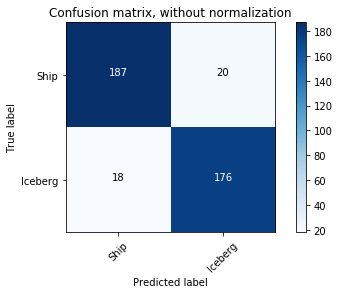

In [148]:
# get predictions
y_pred = modified_VGG16.predict(mod_X_test)
func = lambda x: 1 if x >= 0.5 else 0
y_pred_classes = np.array(list(map(func, y_pred)))
# Compute confusion matrix
cnf_matrix = confusion_matrix(mod_y_test, y_pred_classes)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=classes,
                      title='Confusion matrix, without normalization')



In [149]:
print(classification_report(mod_y_test, y_pred_classes, target_names=classes))

              precision    recall  f1-score   support

        Ship       0.91      0.90      0.91       207
     Iceberg       0.90      0.91      0.90       194

   micro avg       0.91      0.91      0.91       401
   macro avg       0.91      0.91      0.91       401
weighted avg       0.91      0.91      0.91       401



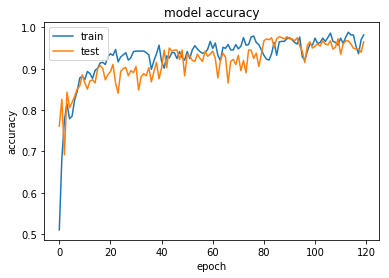

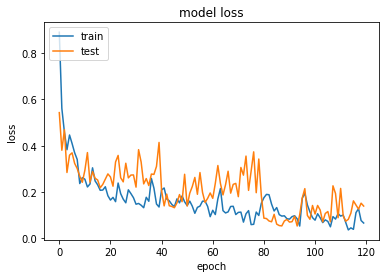

In [150]:
plot_history(history_3)

## Make A Submission (model 3)

In [ ]:
# make predictions of testing data
prediction = modified_VGG16.predict(mod_test_features, verbose=1)

submission= pd.DataFrame({'id': test["id"], 'is_iceberg': prediction.flatten()})
submission.to_csv("../working/tl_submission.csv", index=False)


# Semi-Supervised approach: Pseudo Labelling

In [90]:
# set the best model
best_model = improved_model
print_accuracy(best_model)

Test accuracy: 91.7706%
Test loss: 0.3358


In [91]:
portion_size =int(1.5 * len(X_train)) # (that's 21.4% of the testing set)
test_features_portion = test_features[:portion_size,:,:,:]

# get labels of test data portion
y_pred = best_model.predict(test_features_portion)
func = lambda x: 1 if x >= 0.5 else 0
test_target_portion = np.array(list(map(func, y_pred)))

# setting new data
new_features = np.concatenate((X_train,test_features_portion),axis=0)
new_target = np.concatenate((y_train,test_target_portion),axis=0)

print("% of test portion size: {:0.4}%".format(100*portion_size/len(test_features)))
print("Shape of Features", new_features.shape)
print("Shape of Target", new_target.shape)

% of test portion size: 40.15%
Shape of Features (5637, 75, 75, 2)
Shape of Target (5637,)


In [92]:
# splitting data into training and testing sets
new_X_train, new_X_test, new_y_train, new_y_test = train_test_split(new_features,
                                                                    new_target,
                                                                    test_size=0.25,
                                                                    random_state=5)
print("Total size of dataset:", len(new_features))
print("Size of training set:", len(new_X_train))
print("Size of testing set:", len(new_X_test))

Total size of dataset: 5637
Size of training set: 4227
Size of testing set: 1410


## Model Training (Model 4)

In [94]:
# recompile the model with a new learning rate
opt = Adam(lr=1e-4)
best_model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])

In [95]:
K = 3
epochs = 50
# train the model
X_train = new_X_train
y_train = new_y_train

history_4 = train_with_kfold(best_model, 'pseudo.labeled.model.best.hdf5', epochs=epochs, K=K)



FOLD: 1
Train on 2818 samples, validate on 1409 samples
Epoch 1/50
2818/2818 [==============================] - 5s 2ms/step - loss: 0.1242 - acc: 0.9663 - val_loss: 0.0522 - val_acc: 0.9865

Epoch 00001: val_loss improved from inf to 0.05223, saving model to 1_pseudo.labeled.model.best.hdf5
Epoch 2/50
2818/2818 [==============================] - 4s 1ms/step - loss: 0.1194 - acc: 0.9656 - val_loss: 0.0536 - val_acc: 0.9879

Epoch 00002: val_loss did not improve from 0.05223
Epoch 3/50
2818/2818 [==============================] - 4s 1ms/step - loss: 0.1091 - acc: 0.9688 - val_loss: 0.0513 - val_acc: 0.9858

Epoch 00003: val_loss improved from 0.05223 to 0.05134, saving model to 1_pseudo.labeled.model.best.hdf5
Epoch 4/50
2818/2818 [==============================] - 4s 1ms/step - loss: 0.0861 - acc: 0.9723 - val_loss: 0.0497 - val_acc: 0.9858

Epoch 00004: val_loss improved from 0.05134 to 0.04972, saving model to 1_pseudo.labeled.model.best.hdf5
Epoch 5/50
2818/2818 [===================

2818/2818 [==============================] - 4s 1ms/step - loss: 0.0203 - acc: 0.9961 - val_loss: 0.0426 - val_acc: 0.9858

Epoch 00043: val_loss improved from 0.04318 to 0.04260, saving model to 1_pseudo.labeled.model.best.hdf5
Epoch 44/50
2818/2818 [==============================] - 4s 1ms/step - loss: 0.0157 - acc: 0.9968 - val_loss: 0.0492 - val_acc: 0.9815

Epoch 00044: val_loss did not improve from 0.04260
Epoch 45/50
2818/2818 [==============================] - 4s 1ms/step - loss: 0.0200 - acc: 0.9950 - val_loss: 0.0485 - val_acc: 0.9801

Epoch 00045: val_loss did not improve from 0.04260
Epoch 46/50
2818/2818 [==============================] - 4s 1ms/step - loss: 0.0222 - acc: 0.9950 - val_loss: 0.0505 - val_acc: 0.9801

Epoch 00046: val_loss did not improve from 0.04260
Epoch 47/50
2818/2818 [==============================] - 4s 1ms/step - loss: 0.0159 - acc: 0.9965 - val_loss: 0.0483 - val_acc: 0.9808

Epoch 00047: val_loss did not improve from 0.04260
Epoch 48/50
2818/2818 [

2818/2818 [==============================] - 4s 1ms/step - loss: 0.0045 - acc: 0.9989 - val_loss: 0.0063 - val_acc: 0.9986

Epoch 00028: val_loss did not improve from 0.00331
Epoch 29/50
2818/2818 [==============================] - 4s 1ms/step - loss: 0.0075 - acc: 0.9972 - val_loss: 0.0060 - val_acc: 0.9986

Epoch 00029: val_loss did not improve from 0.00331
Epoch 30/50
2818/2818 [==============================] - 4s 1ms/step - loss: 0.0042 - acc: 0.9986 - val_loss: 0.0057 - val_acc: 0.9986

Epoch 00030: val_loss did not improve from 0.00331
Epoch 31/50
2818/2818 [==============================] - 4s 1ms/step - loss: 0.0093 - acc: 0.9975 - val_loss: 0.0057 - val_acc: 0.9986

Epoch 00031: val_loss did not improve from 0.00331
Epoch 32/50
2818/2818 [==============================] - 4s 1ms/step - loss: 0.0049 - acc: 0.9989 - val_loss: 0.0056 - val_acc: 0.9986

Epoch 00032: val_loss did not improve from 0.00331
Epoch 33/50
2818/2818 [==============================] - 4s 1ms/step - loss: 

## Model Evaluation (Model 4)

In [96]:
# evaluate test accuracy
print("Fold 1")
best_model.load_weights('1_pseudo.labeled.model.best.hdf5')
print('For the new test set:')
print_accuracy(best_model, test_features=new_X_test,test_target=new_y_test)
print('\nFor the old test set:')
print_accuracy(best_model, test_features=X_test,test_target=y_test)
print("----------------------\n")
print("Fold 2")
best_model.load_weights('2_pseudo.labeled.model.best.hdf5')
print('For the new test set:')
print_accuracy(best_model, test_features=new_X_test,test_target=new_y_test)
print('\nFor the old test set:')
print_accuracy(best_model, test_features=X_test,test_target=y_test)
print("----------------------\n")
print("Fold 3")
best_model.load_weights('3_pseudo.labeled.model.best.hdf5')
print('For the new test set:')
print_accuracy(best_model, test_features=new_X_test,test_target=new_y_test)
print('\nFor the old test set:')
print_accuracy(best_model, test_features=X_test,test_target=y_test)
print("----------------------\n")

Fold 1
For the new test set:
Test accuracy: 97.9433%
Test loss: 0.06724

For the old test set:
Test accuracy: 92.0200%
Test loss: 0.5056
----------------------

Fold 2
For the new test set:
Test accuracy: 97.5887%
Test loss: 0.08849

For the old test set:
Test accuracy: 91.5212%
Test loss: 0.5331
----------------------

Fold 3
For the new test set:
Test accuracy: 98.2270%
Test loss: 0.08802

For the old test set:
Test accuracy: 91.5212%
Test loss: 0.6053
----------------------



'\nprint("Fold 4")\nbest_model.load_weights(\'4_pseudo.labeled.model.best.hdf5\')\nprint(\'For the new test set:\')\nprint_accuracy(best_model, test_features=new_X_test,test_target=new_y_test)\nprint(\'\nFor the old test set:\')\nprint_accuracy(best_model, test_features=X_test,test_target=y_test)\n'

In [97]:
# load best weights
best_model.load_weights('2_pseudo.labeled.model.best.hdf5')

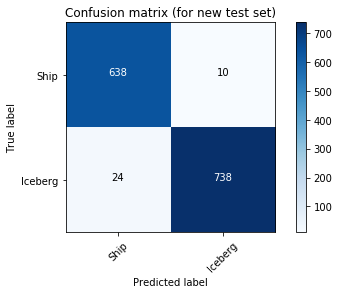

In [98]:
# get predictions
y_pred = best_model.predict(new_X_test)
func = lambda x: 1 if x >= 0.5 else 0
y_pred_classes_1 = np.array(list(map(func, y_pred)))
# Compute confusion matrix
cnf_matrix = confusion_matrix(new_y_test, y_pred_classes_1)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=classes,
                      title='Confusion matrix (for new test set)')


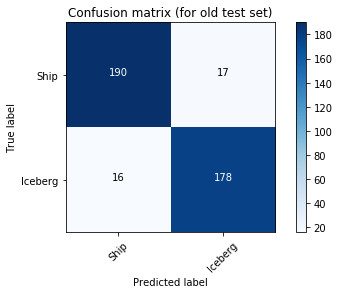

In [86]:
# get predictions
y_pred = best_model.predict(X_test)
func = lambda x: 1 if x >= 0.5 else 0
y_pred_classes_2 = np.array(list(map(func, y_pred)))
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_classes_2)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=classes,
                      title='Confusion matrix (for old test set)')


In [99]:
# classification report on new test set
print(classification_report(new_y_test, y_pred_classes_1, target_names=classes))

              precision    recall  f1-score   support

        Ship       0.96      0.98      0.97       648
     Iceberg       0.99      0.97      0.98       762

   micro avg       0.98      0.98      0.98      1410
   macro avg       0.98      0.98      0.98      1410
weighted avg       0.98      0.98      0.98      1410



In [100]:
# classification report on old test set
print(classification_report(y_test, y_pred_classes_2, target_names=classes))

              precision    recall  f1-score   support

        Ship       0.92      0.92      0.92       207
     Iceberg       0.91      0.92      0.92       194

   micro avg       0.92      0.92      0.92       401
   macro avg       0.92      0.92      0.92       401
weighted avg       0.92      0.92      0.92       401



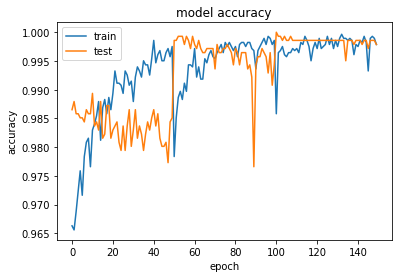

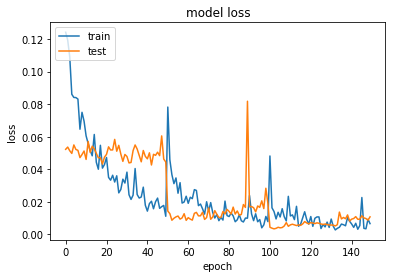

In [101]:
plot_history(history_4)

## Make A Sumbission File  (model 4)

In [ ]:
# make predictions of testing data
prediction = best_model.predict(test_features, verbose=1)

submission= pd.DataFrame({'id': test["id"], 'is_iceberg': prediction.flatten()})
submission.to_csv("../working/pseduolabel_submission.csv", index=False)


With pseduo-labeling, and by retraining the best model on the increased training data we got a better model with 92.02% accuaracy and 0.32 loss.

## AUC of ROC 

In [102]:
y_pred = best_model.predict(X_test)
# Compute roc
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
AUC = keras = auc(fpr, tpr)

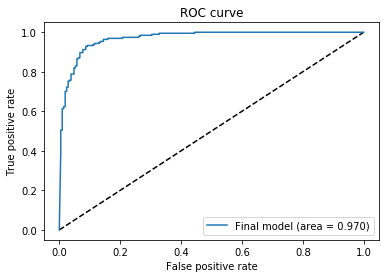

In [103]:
# plot
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Final model (area = {:.3f})'.format(AUC))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


# Conclusion

In the following table, we compare between the benchmark model and the final model:

|Model	| Accuracy	|Loss	|F1-score (ships)|	F1-score (icebergs)|
|-------|---------------|--------|------------------|------------------------|
|Benchmark Model	|83%	|0.35	|0.88 |	0.88|
|Final Model	|92.02%|0.32	|0.92	| 0.92|


When we compare the ROC curves of both models, we find the following:

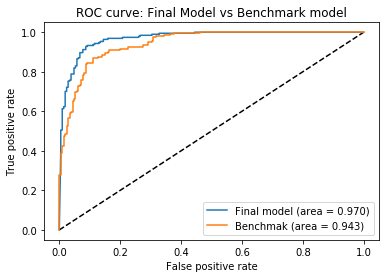

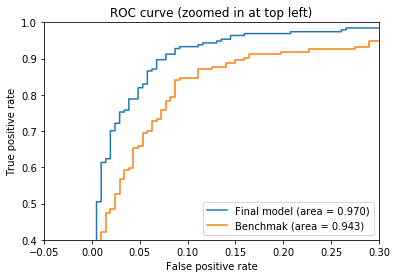

In [104]:
y_pred2 = basic_model.predict(X_test)
# Compute roc
fpr2, tpr2, thresholds2 = roc_curve(y_test, y_pred2)
AUC2 = keras = auc(fpr2, tpr2)

# plot
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Final model (area = {:.3f})'.format(AUC))
plt.plot(fpr2, tpr2, label='Benchmak (area = {:.3f})'.format(AUC2))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve: Final Model vs Benchmark model')
plt.legend(loc='best')
plt.show()

# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(-0.05, 0.3)
plt.ylim(0.4, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Final model (area = {:.3f})'.format(AUC))
plt.plot(fpr2, tpr2, label='Benchmak (area = {:.3f})'.format(AUC2))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

Attribution: https://hackernoon.com/simple-guide-on-how-to-generate-roc-plot-for-keras-classifier-2ecc6c73115a

The final model did a good job in the classification problem with about 92% accuracy, so we want to explore how it performs with different sample images:

In [159]:
samlples_num = 8
# train (from 'train.json': the whole thing, containing both the training and testing splits used for training the model
iceberg_samples = train[train.is_iceberg==1].sample(n=samlples_num)
ships_samples = train[train.is_iceberg==0].sample(n=samlples_num)

In [156]:
from mpl_toolkits.axes_grid1 import ImageGrid

def prepocess_image(img):
    # preprocess images
    label = img.iloc[3]
    band_1 = np.array(img.iloc[0]).astype(np.float32).reshape(75, 75)
    band_2 = np.array(img.iloc[1]).astype(np.float32).reshape(75, 75)
    img = np.concatenate([band_1[:, :, np.newaxis],
                                 band_2[:, :, np.newaxis]], axis=-1)
    img = np.array([img])
    return img, label

def predict_icberg(img):
    predection = best_model.predict(img)
    prob = predection[0]
    predected_label = 1 if predection >= 0.5 else 0
    return predected_label, prob


def show_predictions(images):
    size = len(images)
    fig = plt.figure(1, figsize=(16, 16))
    grid = ImageGrid(fig, 111, nrows_ncols=(2, size//2), axes_pad=0.05)
    for i, (_,img) in enumerate(images.iterrows()):
        img, label = prepocess_image(img)
        predected_label, prob = predict_icberg(img)
        
        color = 'g' if label==predected_label else 'r' 
        ax = grid[i]
        ax.imshow(img[0,:,:,0])
        ax.text(5, 12, 'Predection: %s (%.2f)' % (predected_label, prob),
                color='w', backgroundcolor=color)
        ax.text(3, 5, 'True Label: %s' % label, color='w', backgroundcolor='k')
        ax.axis('off')
    plt.show()
        

Predictions on sample images of icebergs


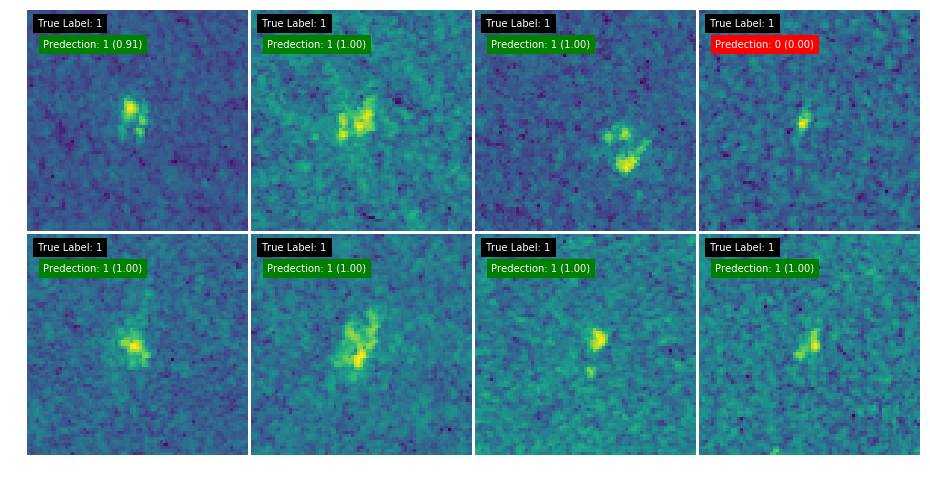

In [157]:
# Show predictions on sample images of icebergs
print("Predictions on sample images of icebergs")
show_predictions(iceberg_samples)

Predictions on sample images of ships


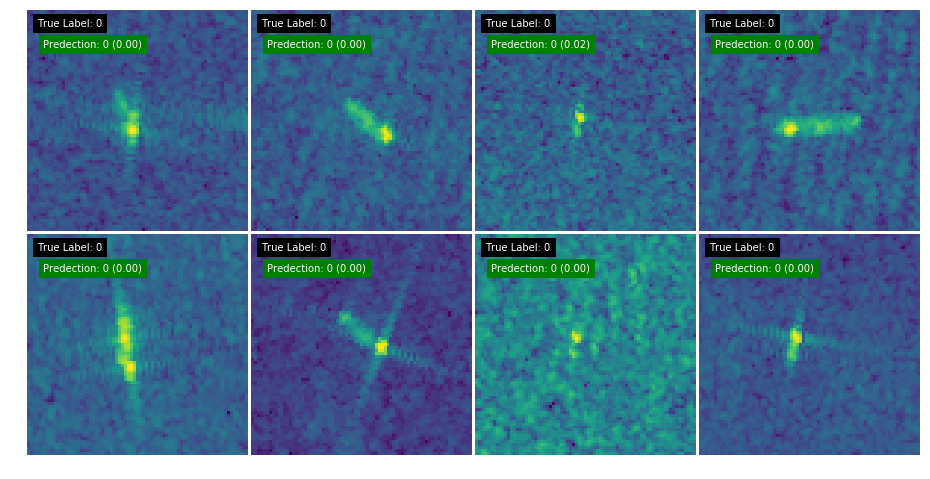

In [160]:
# Show predictions on sample images of ships
print("Predictions on sample images of ships")
show_predictions(ships_samples)

# Summary

* By dimensionality reduction and using classifiers like Random Forest, K-NN and Logistic Regression we didn't get good results and the accuracy didn't exceed 79%.
* Using CNNs has led to better results where a simple CNN benchmark model outperformed the previous methods with ~83% accuracy and up to 90% accuracy after tuning, 0.26 loss and f1-scores of 0.90 and 091 for ship and iceberg classes, respectively.
* By increasing the complexity of the CNN model and introducing more layers we got a better model with ~91.8% accuracy, 0.34 loss, and higher f1-scores of 0.92 and 0.91 for ship and iceberg classes, respectively.
* By making use of transfer learning with VGG16 together with data augmentation, we got 90.5% accuracy, 0.247 loss, and f1-score of 0.91.
* With pseudo-labeling, and by retraining the best obtained model on the increased training data we got a better model with:
    * 95.48% accuracy and 0.1214 loss on the test data (after pseudo-labeling: 752 samples), and f1-scores of 0.95 and 0.96 for ship and iceberg classes, respectively. 
    * 92.02% accuracy and 0.32 loss on the test data (before pseudo-labeling: 401 samples), and f1-score of 0.92 for both ship and iceberg classes.
